In [1]:
# Importing required libraries
import torch  # PyTorch for building and training deep learning models
from dataload import ArtDataset  # Custom dataset class for loading art-related data
from torch.utils.data import Dataset, DataLoader, random_split  # Utilities for data handling
import math  # For mathematical operations
import torch.nn as nn  # PyTorch module for defining neural networks
import numpy as np  # Numerical operations
from sklearn import datasets  # Sample datasets from scikit-learn
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
import matplotlib.pyplot as plt  # For data visualization
import pandas as pd  # Data manipulation and analysis
import torch.optim as optim  # Optimization algorithms for model training
from stringproc import create_vocab_csv, text_to_tensor  # Custom functions for text processing
from transformers import BertModel  # Pre-trained BERT model from HuggingFace Transformers
from torch.optim import Adam  # Adam optimizer for training
import os  # For handling file paths and checking model existence
import pandas as pd  # Pandas for data manipulation

/opt/anaconda3/envs/PyTorch_Tutorial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize the Dataset

In [2]:
# Initialize the dataset and the dataloader
dataset = ArtDataset()

333059
170729
Artist Indexed Tokens: tensor([[ 101, 3434, 3158,  ...,    0,    0,    0],
        [ 101, 2394, 2082,  ...,    0,    0,    0],
        [ 101, 9586, 1012,  ...,    0,    0,    0],
        ...,
        [ 101, 2053, 3914,  ...,    0,    0,    0],
        [ 101, 2053, 3914,  ...,    0,    0,    0],
        [ 101, 2053, 3914,  ...,    0,    0,    0]])
 Artist Segment IDs: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Title Indexed Tokens: tensor([[  101,  1037,  3803,  ...,     0,     0,     0],
        [  101, 14783,  3317,  ...,     0,     0,     0],
        [  101,  1037,  3193,  ...,     0,     0,     0],
        ...,
        [  101, 16660,   102,  ...,     0,     0,     0],
        [  101, 16660,   102,  ...,     0,     0,     0],
        [  101, 16660,   102,  ...,     0,     0,     0]])
 Title Segment

# Split dataset into train, validation (dev), and test sets
Train: 95%
Validation: 2.5%
Test: 2.5%

In [51]:
# Define the dataset sizes
# Calculate the total number of samples in the dataset
total_size = len(dataset)

# Split the dataset into training, validation, and testing sets
# Training set: 95% of the total dataset
train_size = int(0.95 * total_size)

# Validation set: 2.5% of the total dataset
val_size = int(0.025 * total_size)

# Testing set: Remaining samples after allocating for training and validation
# This ensures all samples are utilized without overlapping
test_size = total_size - train_size - val_size

In [52]:
print(train_size, val_size, test_size)

162192 4268 4269


In [53]:
# Split dataset into train, validation (dev), and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [54]:
print(len(train_dataset))

162192


In [94]:
batch = 32  # Define the batch size for loading data

# Create DataLoaders for the training, validation, and test sets
# DataLoader handles batching and shuffling of data for training/validation/testing

# DataLoader for the training dataset
# - batch_size: Number of samples per batch
# - shuffle=True: Shuffle data at every epoch for better generalization
# - num_workers: Number of worker threads to load data (adjust based on hardware)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)

# DataLoader for the validation dataset
# - shuffle=False: No shuffling needed, as validation is a static evaluation
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False, num_workers=2)

# DataLoader for the test dataset
# - shuffle=False: Data should not be shuffled to allow consistent results
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=2)


## Importing and Testing BERT embeddings
BERT allows us to extract context dependent embeddings of each word in a given sentence. For instance, in the phrases "river bank" and "bank of America" the word bank would end up having a drastically different embedding. We test BERT's ability to recognize artist names, and embed them to vectors close to other artists of similar statures and time periods. 

#### INCLUDE CITATION
Chris McCormick and Nick Ryan. (2019, May 14). *BERT Word Embeddings Tutorial*. Retrieved from http://www.mccormickml.com

In [8]:
# Import the pretrained BERT Model
from transformers import BertModel, BertForSequenceClassification

# if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

In [9]:
# Load pre-trained model (weights)
base_model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states
                                  num_labels=13                            
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
base_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [10]:
# function: prediction_to_real_price 
# ------------------------------------------------------
# converts the normalized price tensor back to the original tensor 
# 
# @param price_tensor Tensor containing the price we would like to convert 
# to the original price 
# 
# @returns Original Price
def prediction_to_real_price(price_tensor): 
    return (price_tensor * dataset.price_std) + dataset.price_median

# Sample the Training Set 
index = 1004
artist_tokens_tensor, artist_segids, price_tensor, numerics_tensor, price_classifier = dataset.__getitem__(index)
artist_tokens_tensor = artist_tokens_tensor.view(1, -1)
artist_segids = artist_segids.view(1, -1)
print(artist_tokens_tensor)
print(artist_tokens_tensor.shape)
print(artist_segids)
print(artist_segids.shape)
print(price_classifier)
#artist_str, title_str = dataset.__getstring__(index)
#print(f"Artist: {artist_str}")
#print(f"Title: {title_str}")

tensor([[  101,  1037,  3940,  1997,  3756,  3384,  9226,  2275, 26450, 13767,
          2015,  1010,  1037, 28653,  2275,  3614,  1006,  2962, 13366, 20132,
          1007,  1010,  1037,  2962,  2275,  3614,  1010,  1037,  3940,   102]])
torch.Size([1, 30])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])
torch.Size([1, 30])
tensor([1])


In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Takes in a string and outputs a list of the indices of the 
# words inside, and the tokens 
def encode_text(text): 
    # Add the special tokens.
    marked_text = "[CLS] " + text + " [SEP]"

    # Split the sentence into tokens.
    tokenized_text = tokenizer.tokenize(marked_text)

    # Map the token strings to their vocabulary indeces.
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    return tokenized_text, indexed_tokens

In [12]:
tokenized_text, indexed_tokens = encode_text("Artist Name from Christie Auction Lot: Duane Hanson")

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
artist        3,063
name          2,171
from          2,013
christie     13,144
auction      10,470
lot           2,843
:             1,024
duane        27,319
hanson       17,179
[SEP]           102


In [13]:
# Mark each of the tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
# Convert inputs to PyTorch tensors
tokens_tensor_test = torch.tensor([indexed_tokens])
segments_tensors_test = torch.tensor([segments_ids])

In [15]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers.
with torch.no_grad():

    outputs = base_model(tokens_tensor_test, segments_tensors_test)

    # Evaluating the model will return a different number of objects based on
    # how it's  configured in the `from_pretrained` call earlier. In this case,
    # becase we set `output_hidden_states = True`, the third item will be the
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

In [16]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 11, 768])

In [17]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 11, 768])

In [18]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)

    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 13 x 3072


In [19]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)

    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 13 x 768


In [20]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 artist
2 name
3 from
4 christie
5 auction
6 lot
7 :
8 duane
9 hanson
10 [SEP]


In [21]:
print("Duane", str(token_vecs_sum[8][:7]))
print("Hanson", str(token_vecs_sum[9][:7]))

Duane tensor([ 0.0679, -1.3539,  0.1005, -0.4218,  0.3941,  1.3565,  2.5718])
Hanson tensor([-2.2877e-01, -6.0235e-01, -1.6313e-03, -5.5483e-01,  1.5981e-01,
         1.8523e+00,  2.3278e+00])


In [22]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word Hanson
# in "Duane Hanson" vs the band "Hanson" (different meanings).
diff_hanson = 1 - cosine(token_vecs_sum[2], token_vecs_sum[10])

# Calculate the cosine similarity between the word Hanson
# in "Duane Hanson" vs "Henry Moore" (another sculptor).
sculptors = 1 - cosine(token_vecs_sum[2], token_vecs_sum[5])

print('Vector similarity for  two sculptors:  %.2f' % sculptors)
print('Vector similarity for *different* Hansons:  %.2f' % diff_hanson)

Vector similarity for  two sculptors:  0.80
Vector similarity for *different* Hansons:  0.58


## Define the Models
We define the following models: 
+ A BERT classifier: A pretrained transformer model for classification of sequence text data into a specified number of categories. We will specialize this model to classify the predicted real price ($) of artworks into 13 different price categories: 0-50, 50-100, 100-250, 250-500, 500-750, 750-1000, 1000-5000, 5000-10000, 10000-50000, 50000-100000, 100000-500000, 500000-1M, 1M+. 

In [23]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(set(dataset.price_classifier)),  # Number of classes
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define the loss function as mean average percentage error
We are using this for when we predict the price itself. The reason for this is that we do not want to penalize a prediction that is off by 5 dollars equally for a 1M dollar painting as for a 50 dollar painting. 

In [24]:
# Define percentage error loss
# We use percentage error so that errors on large prices are treated more leniently than errors on small prices 
class MAPE(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPE, self).__init__()
        self.epsilon = epsilon  # Small constant to avoid division by zero

    def forward(self, predictions, targets):
        # Calculate MAPE
        percentage_errors = torch.abs((targets - predictions) / (targets + self.epsilon))
        mape = 100.0 * torch.mean(percentage_errors)
        return mape

## Train the models using Mini-Batch Gradient Descent with ADAM

In [25]:
from transformers import AdamW
from torch.optim import lr_scheduler

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

/opt/anaconda3/envs/PyTorch_Tutorial/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
from torch.nn import CrossEntropyLoss
from transformers import get_scheduler

# Loss function
criterion = CrossEntropyLoss()

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1

losses = []
epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    for artist, artist_seg_ids, price, numerics, price_classifier in train_loader:
        print("Zeroing out the gradients")
        optimizer.zero_grad()

        # Forward pass
        print("Making the forward pass")
        outputs = model(input_ids=artist, attention_mask=artist_seg_ids, 
                        labels=price_classifier)
        print("Computing the loss")
        loss = outputs.loss
        print(f'Loss: {loss.item()}')
        losses.append(loss.item())

        print("Doing backward propagation")
        loss.backward()

        print("Adjusting the parameters")
        optimizer.step()

    # Save a copy of the model weights after each epoch so we don't lose our progress
    model.save_pretrained("./fine_tuned_bert")
    epoch_losses.append(loss.item())
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Scheduler step
    scheduler.step()

Zeroing out the gradients
Making the forward pass
Computing the loss
Loss: 12.912093162536621
Doing backward propagation


KeyboardInterrupt: 

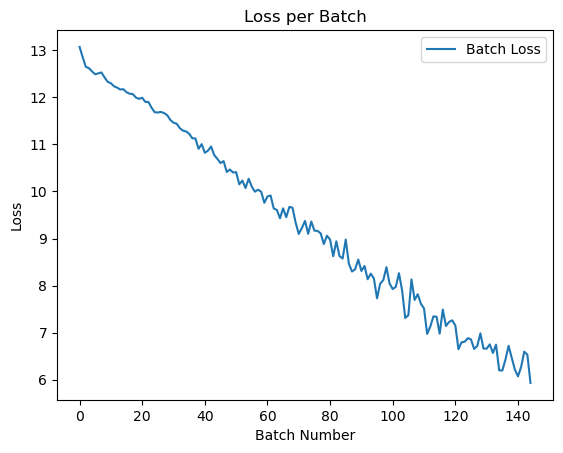

In [ ]:
# Plot the loss curve
plt.plot(losses, label="Batch Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Loss per Batch")
plt.legend()
plt.show()

## Predicting Prices with Extracted Sentenced Embeddings
We define a deep learning model that combines pre-trained BERT embeddings and numerical features to predict art prices for artwork with a real price under $3,000 USD. This model uses BERT to process the artist and title, map these embeddings and numerical features through separate fully connected layers, and concatenate them to predict a single real price value through an output layer.

In [95]:
# Define the ShallowArtPricePredictionModel class
class ShallowArtPricePredictionModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', numerical_dim=13, embedding_dim=768, hidden_dim=256):
        """
        Initializes the shallow model for art price prediction.
        Arguments:
        - bert_model_name: Pre-trained BERT model name from HuggingFace Transformers.
        - numerical_dim: Number of numerical input features.
        - embedding_dim: Dimensionality of BERT embeddings.
        - hidden_dim: Dimensionality of the hidden layers.
        """
        super(ShallowArtPricePredictionModel, self).__init__()
        
        # Load pre-trained BERT model for text embeddings
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Fully connected layers for processing artist and title embeddings
        self.artist_fc = nn.Linear(embedding_dim, hidden_dim)
        self.title_fc = nn.Linear(embedding_dim, hidden_dim)
        
        # Fully connected layer for processing numerical data
        self.numerical_fc = nn.Linear(numerical_dim, hidden_dim)
        
        # Output layer to predict a single price value
        self.output_fc = nn.Linear(hidden_dim * 3, 1)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, artist_input_ids, artist_attention_mask, title_input_ids, title_attention_mask, numerics):
        """
        Forward pass for the model.
        Arguments:
        - artist_input_ids: Tokenized input IDs for artist text.
        - artist_attention_mask: Attention mask for artist text.
        - title_input_ids: Tokenized input IDs for title text.
        - title_attention_mask: Attention mask for title text.
        - numerics: Numerical input features.
        Returns:
        - price_prediction: Predicted price value for the input data.
        """
        # Extract BERT embeddings without updating the BERT weights
        with torch.no_grad():
            artist_output = self.bert(input_ids=artist_input_ids, attention_mask=artist_attention_mask)
            title_output = self.bert(input_ids=title_input_ids, attention_mask=title_attention_mask)
        
        # Pool embeddings by averaging the hidden states
        artist_embedding = artist_output.last_hidden_state.mean(dim=1)
        title_embedding = title_output.last_hidden_state.mean(dim=1)
        
        # Process embeddings through their respective fully connected layers
        artist_features = self.relu(self.artist_fc(artist_embedding))
        title_features = self.relu(self.title_fc(title_embedding))
        
        # Process numerical data through its fully connected layer
        numerical_features = self.relu(self.numerical_fc(numerics))
        
        # Concatenate all features into a single tensor
        combined_features = torch.cat([artist_features, title_features, numerical_features], dim=1)
        
        # Predict price using the final output layer
        price_prediction = self.output_fc(combined_features)
        
        return price_prediction


# Define hyperparameters
embedding_dim = 768  # Dimensionality of BERT embeddings
numerical_dim = 13  # Number of numerical features
hidden_dim = 256  # Hidden layer dimensionality

# Path to the model weights file
model_path = "art_price_prediction_model.pth"
print(os.path.abspath(model_path))
absolute = os.path.abspath(model_path)

# Initialize the model
model = ShallowArtPricePredictionModel(
    bert_model_name='bert-base-uncased',
    numerical_dim=numerical_dim,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim
)

# Check if the model weights file exists
if os.path.exists(absolute):
    # Load model weights if the file is available
    model.load_state_dict(torch.load(absolute))
    print("Model weights loaded successfully!")
else:
    # Inform the user if no weights file is found
    print(f"No weights found at {model_path}. Starting with randomly initialized weights.")

/Users/dalva/Documents/GitHub/AuctionNet/art_price_prediction_model.pth


/var/folders/9_/bw7wstp94sj7ykxwj9wzzbcw0000gn/T/ipykernel_98155/3575370603.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(absolute))


Model weights loaded successfully!


In [119]:
# Initialize device for computation
# Check if CUDA (GPU support) is available, otherwise check for Apple MPS, fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use GPU for acceleration
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple Metal Performance Shaders if available
else:
    device = torch.device("cpu")  # Default to CPU
print(device)  # Print the selected device

# Move the model to the selected device (CPU, GPU, or MPS)
model.to(device)

# Define the Huber loss function
# Huber loss is less sensitive to outliers in data compared to MSE
# `delta` controls the transition between quadratic and linear loss
delta = 1.4  # Default value; adjust based on the specific problem
criterion = nn.HuberLoss(delta=delta)

# Define the optimizer
# Adam optimizer adjusts learning rates for each parameter adaptively
learning_rate = 1e-4  # Small learning rate to ensure stable convergence
optimizer = Adam(model.parameters(), lr=learning_rate)

mps


In [120]:
losses = []
avg_losses = []
model.train()
num_epochs = 10
clip_value = 2.0  # Set the maximum norm for gradient clipping

for epoch in range(num_epochs):
    epoch_loss = 0
    batch_no = 0
    for batch in train_loader:
        # Unpack the batch
        artist_ids = batch[0].to(device)         # Move to device
        artist_seg_ids = batch[1].to(device)    # Move to device
        price = batch[2].to(device)             # Move to device
        numerics = batch[3].to(device)          # Move to device
        price_classifier = batch[4].to(device)  # Move to device
        title_ids = batch[5].to(device)         # Move to device
        title_seg_ids = batch[6].to(device)     # Move to device

        optimizer.zero_grad()

        # Forward pass
        predictions = model(artist_ids, artist_seg_ids, title_ids, title_seg_ids, numerics)

        # Compute loss
        loss = criterion(price, predictions)
        losses.append(loss.item())
        
        if batch_no % 100 == 0:  # Print every 100 batches
            print(f"Epoch: {epoch}, Batch: {batch_no}, Loss: {loss.item()}")

        # Backward pass
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Optimization step
        optimizer.step()
        epoch_loss += loss.item()
        
        if batch_no % 10 == 0:
            torch.save(model.state_dict(), "art_price_prediction_model.pth")
        batch_no += 1
    
    avg_loss = epoch_loss / len(train_loader)
    avg_losses.append(avg_loss)

    # Save the trained model
    torch.save(model.state_dict(), "art_price_prediction_model.pth")
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss*100}")

# Save the trained model
torch.save(model.state_dict(), "art_price_prediction_model.pth")

Epoch: 0, Batch: 0, Loss: 0.1757746934890747
Epoch: 0, Batch: 100, Loss: 0.14430832862854004
Epoch: 0, Batch: 200, Loss: 0.1511898636817932
Epoch: 0, Batch: 300, Loss: 0.1824943721294403
Epoch: 0, Batch: 400, Loss: 0.24368597567081451
Epoch: 0, Batch: 500, Loss: 0.14041349291801453
Epoch: 0, Batch: 600, Loss: 0.21740983426570892
Epoch: 0, Batch: 700, Loss: 0.18849803507328033
Epoch: 0, Batch: 800, Loss: 0.12215124070644379
Epoch: 0, Batch: 900, Loss: 0.24925023317337036
Epoch: 0, Batch: 1000, Loss: 0.11085349321365356
Epoch: 0, Batch: 1100, Loss: 0.11554807424545288
Epoch: 0, Batch: 1200, Loss: 0.14253786206245422
Epoch: 0, Batch: 1300, Loss: 0.10118389129638672
Epoch: 0, Batch: 1400, Loss: 0.13011755049228668
Epoch: 0, Batch: 1500, Loss: 0.22445428371429443
Epoch: 0, Batch: 1600, Loss: 0.16097041964530945
Epoch: 0, Batch: 1700, Loss: 0.27604883909225464
Epoch: 0, Batch: 1800, Loss: 0.17447715997695923
Epoch: 0, Batch: 1900, Loss: 0.1667855679988861
Epoch: 0, Batch: 2000, Loss: 0.18626

KeyboardInterrupt: 

In [121]:
# Save the model's state dictionary
# The state dictionary contains the model's learned parameters (weights and biases)
torch.save(model.state_dict(), "art_price_prediction_model.pth")

In [ ]:
# Plot the loss curve
plt.plot(losses, label="Training Loss (MAPE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

In [ ]:
# Plot the average loss curve
plt.plot(avg_losses, label="Average Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Avg Loss per Epoch")
plt.legend()
plt.show()

### Computing Accuracy on the Test Set
We compute accuracy on several key metrics: mean absolute percentage error, mean absolute error, mean squared error, and root mean squared error. We will compare our model's performance on these metrics to the baseline human performance (see the human performance computations below in the notebook).

In [126]:
# Define MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error.
    epsilon: Small value added to avoid division by zero.
    """
    epsilon = 1e-10  # To avoid division by zero
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Define MAE (Mean Absolute Error)
def mean_absolute_error(y_true, y_pred):
    """
    Calculate Mean Absolute Error.
    """
    return torch.mean(torch.abs(y_true - y_pred))

# Define MSE (Mean Squared Error)
def mean_squared_error(y_true, y_pred):
    """
    Calculate Mean Squared Error.
    """
    return torch.mean((y_true - y_pred) ** 2)

# Set the model to evaluation mode
model.eval()
num_epochs = 1  # Number of epochs to evaluate (usually one for testing)

# Initialize accumulators for metrics
total_mape = 0  # Cumulative MAPE
total_mae = 0   # Cumulative MAE
total_rmse = 0  # Cumulative RMSE
num_batches = 0 # Number of processed batches

# Iterate through the test data loader
for batch in test_loader:
    # Unpack the batch
    artist_ids = batch[0].to(device)         # Artist input IDs
    artist_masks = batch[1].to(device)      # Artist attention masks
    numerics = batch[3].to(device)          # Numerical features
    price = batch[2].to(device)             # Normalized prices (target variable)

    # Perform forward pass without gradient calculation
    with torch.no_grad():
        # Make predictions using the model
        predictions = model(artist_ids, artist_masks, artist_ids, artist_masks, numerics)
        
        # Denormalize the prices
        std = dataset.price_std.to(device)  # Standard deviation of prices
        median = dataset.price_median.to(device)  # Median of prices
        real_price = price * std + median  # Denormalize ground truth prices
        real_predictions = predictions * std + median  # Denormalize predictions
        
        # Compute metrics
        mape = mean_absolute_percentage_error(real_price, real_predictions)
        mae = mean_absolute_error(real_price, real_predictions)
        mse = mean_squared_error(real_price, real_predictions)
        rmse = torch.sqrt(mse)  # Root Mean Squared Error
        
        # Update totals for averaging
        total_mape += mape.item()
        total_mae += mae.item()
        total_rmse += rmse.item()
        num_batches += 1

        # Debugging outputs
        print(f"Real Prices: {real_price}")
        print(f"Predictions: {real_predictions}")
        print(f"Batch MAPE: {mape.item()}")
        print(f"Batch MAE: {mae.item()}")
        print(f"Batch RMSE: {rmse.item()}")

# Compute average metrics
avg_mape = total_mape / num_batches
avg_mae = total_mae / num_batches
avg_rmse = total_rmse / num_batches

# Output the final evaluation results
print(f"Mean Absolute Percentage Error (MAPE): {avg_mape:.2f}%")
print(f"Mean Absolute Error (MAE): {avg_mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {avg_rmse:.2f}")

Real Prices: tensor([[ 572.4909],
        [ 663.2948],
        [ 452.8797],
        [ 912.9597],
        [1689.9630],
        [1017.4081],
        [ 159.8838],
        [1643.3567],
        [ 596.0931],
        [ 900.1832],
        [ 634.5880],
        [ 410.3115],
        [ 527.4539],
        [1242.8536],
        [1048.9657],
        [ 469.1796],
        [ 503.5441],
        [ 361.6356],
        [2579.5596],
        [2454.8555],
        [2271.3638],
        [1674.7366],
        [1645.2714],
        [2650.0679],
        [ 712.0122],
        [2268.3511],
        [ 920.5490],
        [2026.2056],
        [  96.8947],
        [ 953.1998],
        [ 336.6858],
        [2422.4917]], device='mps:0')
Predictions: tensor([[ 799.4538],
        [1112.0223],
        [ 675.9952],
        [ 588.5443],
        [1250.3259],
        [ 957.2700],
        [ 266.8752],
        [1477.0234],
        [1075.8650],
        [1021.6814],
        [ 761.4486],
        [ 445.5306],
        [1020.8871],
        [163

### Huber Loss Computations
We evaluate the model on a validation dataset to compute residuals (absolute differences between predicted and true values). Residuals are analyzed here in order to determine the optimal delta parameter for Huber loss, using percentile-based thresholds (e.g., 90th percentile) to balance sensitivity to errors and robustness to outliers.

In [30]:
# Set the model to evaluation mode
model.eval()

# Initialize accumulators
residuals = []  # List to store residuals (absolute differences between true and predicted values)
epoch_loss = 0  # Placeholder for tracking loss (if needed for logging)

# Loop through the validation data loader
for batch in val_loader:
    # Unpack the batch
    artist_ids = batch[0].to(device)         # Tokenized input IDs for artist text
    artist_masks = batch[1].to(device)      # Attention masks for artist text
    numerics = batch[3].to(device)          # Numerical features
    price = batch[2].to(device)             # Normalized target prices (ground truth)

    # Perform forward pass without gradient computation
    with torch.no_grad():
        # Get predictions from the model
        predictions = model(artist_ids, artist_masks, artist_ids, artist_masks, numerics)
        
        # Compute residuals (absolute differences between predicted and true values)
        batch_residuals = torch.abs(price - predictions).cpu().numpy()
        
        # Extend residuals list with current batch residuals
        residuals.extend(batch_residuals)

# Convert residuals to a NumPy array for easier manipulation
residuals = np.array(residuals)

# Determine the optimal delta for Huber loss
# Using the 90th percentile of residuals as the threshold for delta
optimal_delta = np.percentile(residuals, 90)

# Output the optimal delta value
print(f"Optimal delta (90th percentile of residuals): {optimal_delta}")

Optimal delta (90th percentile of residuals): 1.3471452593803406


Delta at 75th percentile: 0.6034871190786362
Delta at 80th percentile: 0.7006887435913086
Delta at 85th percentile: 0.8316157281398772
Delta at 90th percentile: 1.0059808015823366
Delta at 95th percentile: 1.3201445221900938
Optimal delta (90th percentile): 1.0059808015823366


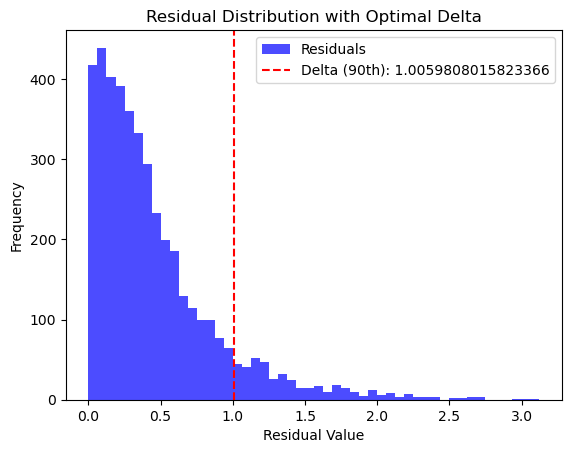

In [116]:
# Evaluate model and compute residuals
model.eval()
residuals = []  # To store residuals

for batch in val_loader:
    # Unpack the batch
    artist_ids = batch[0].to(device)         # Artist input IDs
    artist_masks = batch[1].to(device)      # Artist attention masks
    numerics = batch[3].to(device)          # Numerical features
    price = batch[2].to(device)             # Normalized prices (target)

    # Forward pass
    with torch.no_grad():
        predictions = model(artist_ids, artist_masks, artist_ids, artist_masks, numerics)
        
        # Compute residuals (absolute differences)
        batch_residuals = torch.abs(price - predictions).cpu().numpy()
        residuals.extend(batch_residuals)  # Store residuals

# Convert residuals to a NumPy array for analysis
residuals = np.array(residuals)

# Analyze residuals to determine delta
percentiles = [75, 80, 85, 90, 95]  # Percentiles to analyze
deltas = {p: np.percentile(residuals, p) for p in percentiles}

# Display delta for each percentile
for p, delta in deltas.items():
    print(f"Delta at {p}th percentile: {delta}")

# Choose the optimal delta (90th percentile as an example)
optimal_delta = deltas[90]
print(f"Optimal delta (90th percentile): {optimal_delta}")

# Plot residual distribution and delta
plt.hist(residuals, bins=50, alpha=0.7, color='blue', label="Residuals")
plt.axvline(x=optimal_delta, color='red', linestyle='--', label=f'Delta (90th): {optimal_delta}')
plt.title("Residual Distribution with Optimal Delta")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Compute human error
Compute the human error (absolute percentage error, mean absolute percentage error, mean absolute error, and root mean squared error) based on choosing the midpoint of the auctioneer's estimate as the auctioneer's prediction for that lot.

In [123]:
# Load the CSV file containing art price data
file_path = 'clean_art.csv'  # Path to the dataset
data = pd.read_csv(file_path)  # Read the CSV file into a pandas DataFrame

# Calculate the human-predicted price as the midpoint of the lower and upper bound estimates
# 'Real LB Estimate USD' and 'Real UB Estimate USD' represent the range of estimated prices
data['Human Predicted Price'] = (data['Real LB Estimate USD'] + data['Real UB Estimate USD']) / 2

# Filter rows where the actual price is less than 3000
# This focuses the analysis on a specific subset of the data
data = data[data["Real Price USD"] < 3000]

# Calculate the Absolute Percentage Error (APE) for each row
# APE measures the relative error between the predicted and actual prices
data['Absolute Percentage Error'] = abs(data['Human Predicted Price'] - data['Real Price USD']) / data['Real Price USD']

# Calculate Mean Absolute Percentage Error (MAPE)
# MAPE is the average of the absolute percentage errors across all rows
mape = data['Absolute Percentage Error'].mean() * 100

# Calculate Mean Absolute Error (MAE)
# MAE is the average of the absolute differences between predicted and actual prices
data['Absolute Error'] = abs(data['Human Predicted Price'] - data['Real Price USD'])
mae = data['Absolute Error'].mean()

# Calculate Root Mean Squared Error (RMSE)
# RMSE measures the average magnitude of the prediction error, penalizing larger errors
data['Squared Error'] = (data['Human Predicted Price'] - data['Real Price USD']) ** 2
rmse = np.sqrt(data['Squared Error'].mean())

# Output the results
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.2f} USD")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} USD")


Mean Absolute Percentage Error (MAPE): 42.54%
Mean Absolute Error (MAE): 386.76 USD
Root Mean Squared Error (RMSE): 621.18 USD
